# Unsupervised Learning with Altimetry Classification -- Assignment 4

In this notebook are the following:
1. Classification of sea ice and leads using Gaussian Mixture Models (GMM) with altimetry data from Sentinel-3.
2. Graphs of the classified echoes to analyse them.
3. A confusion matrix comparing our GMM-classified results with the official ESA classification.

Now, let's explore the application of these unsupervised methods to altimetry classification tasks, focusing specifically on distinguishing between sea ice and leads in Sentinel-3 altimetry dataset.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read in Functions Needed
Before delving into the modeling process, it's crucial to preprocess the data to ensure compatibility with our analytical models. This involves transforming the raw data into meaningful variables, such as peakniness and stack standard deviation (SSD), etc.

In [2]:
! pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.1 MB/s eta 0:00:00


In [3]:
#
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
# from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree

import pyproj
# import cartopy.crs as ccrs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster

#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================
#Credit: Isobel Lawrence

#*args and **kwargs allow you to pass an unspecified number of arguments to a function,
#so when writing the function definition, you do not need to know how many arguments will be passed to your function
#**kwargs allows you to pass keyworded variable length of arguments to a function.
#You should use **kwargs if you want to handle named arguments in a function.
#double star allows us to pass through keyword arguments (and any number of them).

# Feed it the echo, it calculates max/min and returns the value of the [false]? peakiness
def peakiness(waves, **kwargs):

    "finds peakiness of waveforms."

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

# This function gets out certain variables
def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

# This function calculates stack-standard deviation
def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    from scipy import asarray as ar,exp
    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD


**Please note that for the following block, you must set the `path` variable to the path on your own drive of the location containing the SAR file.**

In [4]:
path = '/content/drive/MyDrive/UMD/Spring 24 UCL/GEOL0069/Week_4/' # You need to specify the path

SAR_file='S3B_SR_2_LAN_SI_20190301T231304_20190301T233006_20230405T162425_1021_022_301______LN3_R_NT_005.SEN3' #This should be the ALTIMETRY SEN-3 data
print('overlapping SAR file is',SAR_file)
SAR_data=Dataset(path + SAR_file+'/enhanced_measurement.nc')

# We are unpacking thresholds provided by ESA. Classified as leads, ice, ocean, and [land & unclassified] (one group)
SAR_lat, SAR_lon, waves, sig_0, RIP, flag = unpack_gpod('lat_20_ku'), unpack_gpod('lon_20_ku'), unpack_gpod('waveform_20_ku'),unpack_gpod('sig0_water_20_ku'),unpack_gpod('rip_20_ku'),unpack_gpod('surf_type_class_20_ku') #unpack_gpod('Sigma0_20Hz')
SAR_index=np.arange(np.size(SAR_lat))

find=np.where(SAR_lat >= -99999)#60
SAR_lat=SAR_lat[find]
SAR_lon=SAR_lon[find]
SAR_index=SAR_index[find]
waves=waves[find]
sig_0=sig_0[find]
RIP=RIP[find]

PP=peakiness(waves)
SSD=calculate_SSD(RIP)
sig_0_np = np.array(sig_0)  # Replace [...] with your data
RIP_np = np.array(RIP)
PP_np = np.array(PP)
SSD_np = np.array(SSD)

data = np.column_stack((sig_0_np,PP_np, SSD_np))
# Standardize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

overlapping SAR file is S3B_SR_2_LAN_SI_20190301T231304_20190301T233006_20230405T162425_1021_022_301______LN3_R_NT_005.SEN3
Running peakiness function...


<ipython-input-3-2f45626d8a02>:70: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


In [5]:
# We calculated for all 13,000 echos on this track.
# We have three indices, which are sigma-0, pulse-pickiness, and stack-standard deviation
data_normalized.shape

(13101, 3)

There are some NaN values within the data. These values should be removed. In addition, let us only select bands containing flags for either sea ice or leads, as other flags are not useful.

In [6]:
# Makes it such that NaN values are ignored
flag_cleaned = flag[~np.isnan(data_normalized).any(axis=1)]

nan_count = np.isnan(data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")
data_cleaned = data_normalized[~np.isnan(data_normalized).any(axis=1)]

# Only select bands that have a flag that is either sea ice or lead
waves_cleaned=waves[~np.isnan(data_normalized).any(axis=1)][(flag_cleaned==1)|(flag_cleaned==2)]

Number of NaN values in the array: 387


## Examining ESA Data

Taking a quick look at the data, we plot the normalized echoes divided by the sum of the values. The echoes are normalized by dividing each value by the sum of all values in the function. This ensures all echoes have a similar "weight" in the plot.

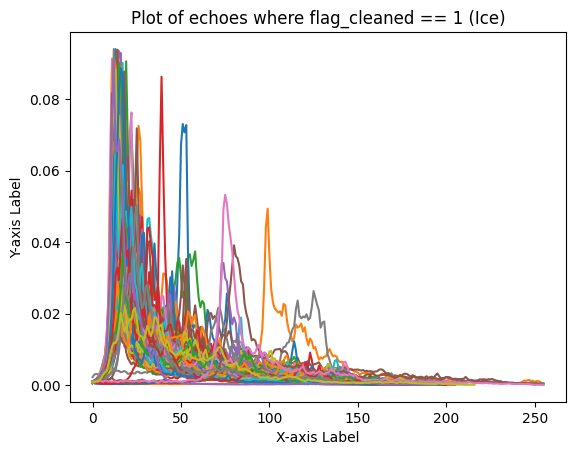

In [7]:
# Plot of echoes where flag_cleaned == 1 (ice)

functions_to_plot = waves[~np.isnan(data_normalized).any(axis=1)][(flag_cleaned==1)][::10] # Plot for every 10 of these echoes. We are plotting the "1s" aka ice

threshold = 0.0006 # Threshold value for truncation (adjust as needed)

# Plot each function
for i, function in enumerate(functions_to_plot):
    # Normalize function
    normalized_function = function/np.sum(function)

    # Find the first index where function exceeds the threshold and truncate it
    truncation_index = np.where(normalized_function > threshold)[0][0]
    truncated_function = normalized_function[truncation_index:]

    plt.plot(truncated_function)

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Plot of echoes where flag_cleaned == 1 (Ice)')
# plt.legend()
plt.show()

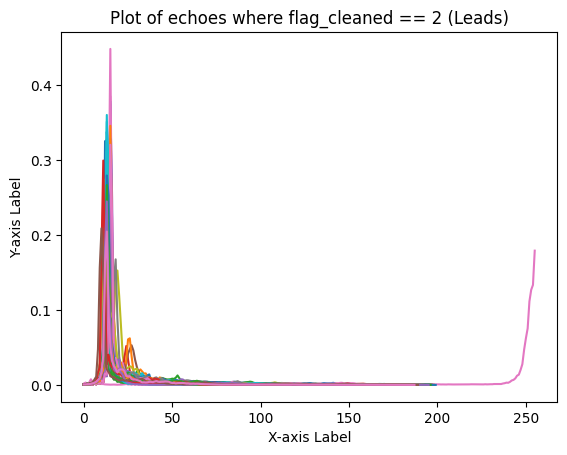

In [8]:
# Plot of echoes where flag_cleaned == 2 (leads)

functions_to_plot = waves[~np.isnan(data_normalized).any(axis=1)][(flag_cleaned==2)][::10] #Here we are doing it for leads

threshold = 0.0006 # Threshold value for truncation (adjust as needed)

# Plot each function
for i, function in enumerate(functions_to_plot):
    # Normalize function
    normalized_function = function/np.sum(function)

    # Find the first index where function exceeds the threshold and truncate it
    truncation_index = np.where(normalized_function > threshold)[0][0]
    truncated_function = normalized_function[truncation_index:]

    plt.plot(truncated_function)

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Plot of echoes where flag_cleaned == 2 (Leads)')
# plt.legend()
plt.show()

## Running Gaussian Mixture Model

Now, let's proceed with running the GMM model as usual. We are trying to classify the echoes in leads and sea ice.

In [9]:
# This is where we use the ML algorithm!

gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)])
clusters_gmm = gmm.predict(data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)])

We can inspect how many data points are there in each class of the clustering prediction.

In [10]:
unique, counts = np.unique(clusters_gmm, return_counts=True)
class_counts = dict(zip(unique, counts))

print(class_counts)

{0: 5013, 1: 1836}


## Examining GMM Data

Now that the model has been run, let's take a look at the classification by using some graphs, starting with the predictions for ice.

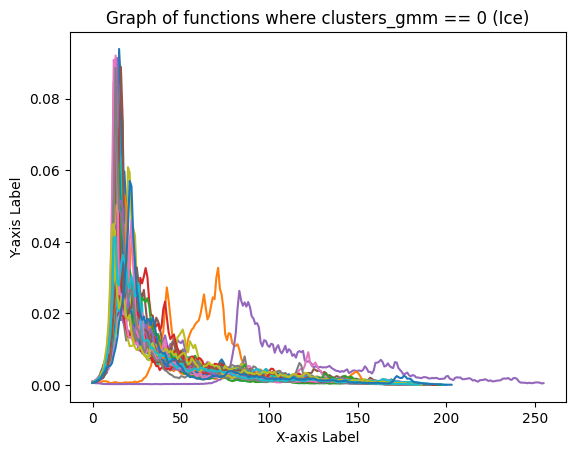

In [11]:
# Extract the functions where clusters_gmm is equal to 0 (ice) and truncate graph dynamically

functions_to_plot = waves_cleaned[clusters_gmm == 0][::100]

threshold = 0.0006 # Threshold value for truncation (adjust as needed)

# Plot each function
for i, function in enumerate(functions_to_plot):
    # Normalize function
    normalized_function = function/np.sum(function)

    # Find the first index where function exceeds the threshold and truncate it
    truncation_index = np.where(normalized_function > threshold)[0][0]
    truncated_function = normalized_function[truncation_index:]

    plt.plot(truncated_function)

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Graph of functions where clusters_gmm == 0 (Ice)')
plt.show()

Now we examine the graph for leads.

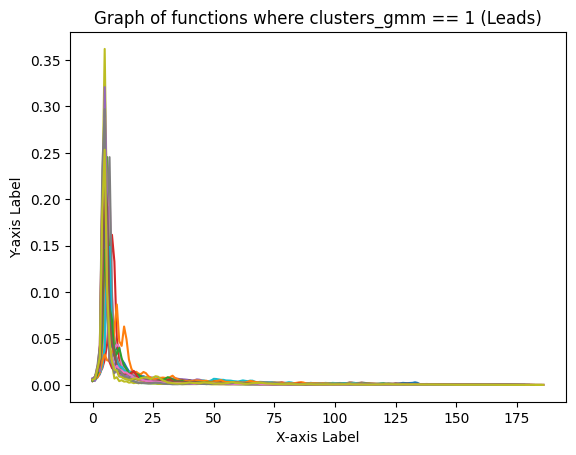

In [12]:
# Extract the functions where clusters_gmm is equal to 1 (leads) and truncate graph dynamically

functions_to_plot = waves_cleaned[clusters_gmm == 1][::100]

threshold = 0.004 # Threshold value for truncation (adjust as needed)

# Plot each function
for i, function in enumerate(functions_to_plot):
    # Normalize function
    normalized_function = function/np.sum(function)

    # Find the first index where function exceeds the threshold and truncate it
    truncation_index = np.where(normalized_function > threshold)[0][0]
    truncated_function = normalized_function[truncation_index:]

    plt.plot(truncated_function)

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Graph of functions where clusters_gmm == 1 (Leads)')
plt.show()

### Average Echo Shape and Standard Deviation

In addition to these two graphs, let us produce an average echo shape as well as standard deviation for these two classes.


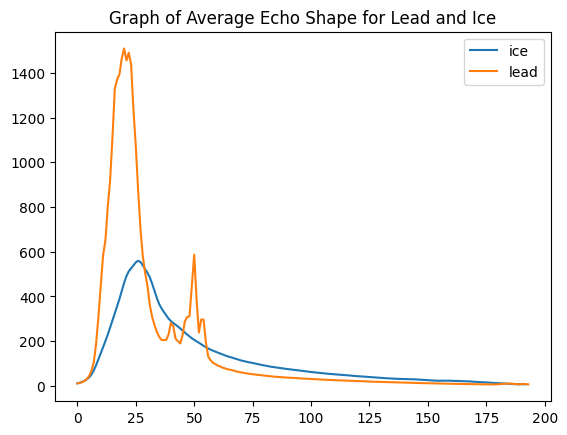

In [13]:
# Graph of average echo shape of ice and lead

ice_avg = np.mean(waves_cleaned[clusters_gmm==0],axis=0)
lead_avg = np.mean(waves_cleaned[clusters_gmm==1],axis=0)

avg_threshold = 10 # Modify as necessary. Determines graph cutoff at start

# Find index at which to begin truncation
ice_truncation_index_avg = np.where(ice_avg > avg_threshold)[0][0]
lead_truncation_index_avg = np.where(lead_avg > avg_threshold)[0][0]

# Perform truncation
truncated_ice_avg = ice_avg[ice_truncation_index_avg:]
truncated_lead_avg = lead_avg[lead_truncation_index_avg:]

# Plot truncated averages
plt.plot(truncated_ice_avg, label='ice')
plt.plot(truncated_lead_avg, label='lead')
plt.title("Graph of Average Echo Shape for Lead and Ice")
plt.legend()

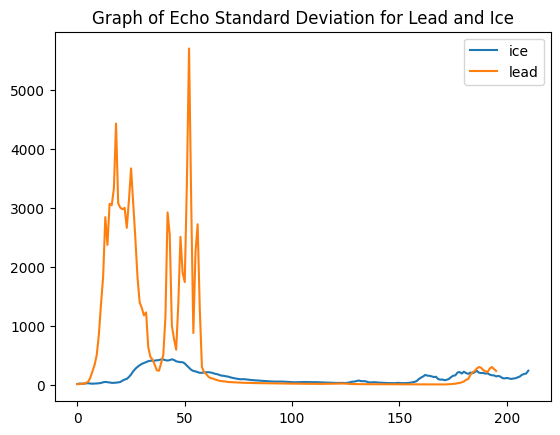

In [14]:
# Graph of standard devation of echo for ice and lead

ice_std = np.std(waves_cleaned[clusters_gmm==0],axis=0)
lead_std = np.std(waves_cleaned[clusters_gmm==1],axis=0)

std_threshold = 10 # Modify as necessary. Determines graph cutoff at start

# Find index at which to begin truncation
ice_truncation_index_std = np.where(ice_std > std_threshold)[0][0]
lead_truncation_index_std = np.where(lead_std > std_threshold)[0][0]

# Perform truncation
truncated_ice_std = ice_std[ice_truncation_index_std:]
truncated_lead_std = lead_std[lead_truncation_index_std:]

# Plot truncated averages
plt.plot(truncated_ice_std, label='ice')
plt.plot(truncated_lead_std, label='lead')
plt.title("Graph of Echo Standard Deviation for Lead and Ice")
plt.legend()

## Confusion Matrix

Now that we have our own GMM classification, it is good to perform a check of accuracy against the existing ESA classification. This can be done using a confusion matrix, similar to what was done in Week 1 of this course.

The following code will quantify our echo classification against the ESA official classification using a confusion matrix. Some cleaning of the data must be done first, however, as the labels for GMM and ESA are assigned differently (ESA assigns 2 to leads and GMM assigns 1 to leads).

In [15]:
# Convert class_counts into a list containing 5013 0's and 1836 1's (0 = ice, 1 = lead)
gmm_labels = np.concatenate([[key] * value for key, value in class_counts.items()])

In [16]:
# Filter out ice and lead flags (1 = ice and 2 = leads)
esa_labels = flag_cleaned[(flag_cleaned == 1) | (flag_cleaned == 2)]

# Shift all labels down by one so that the same schema is being used for gmm_labels and esa_labels (e.g. 0 = ice, 1 = lead)
esa_labels = esa_labels - 1

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.83      0.84      5086
         1.0       0.54      0.56      0.55      1763

    accuracy                           0.76      6849
   macro avg       0.69      0.70      0.70      6849
weighted avg       0.77      0.76      0.77      6849



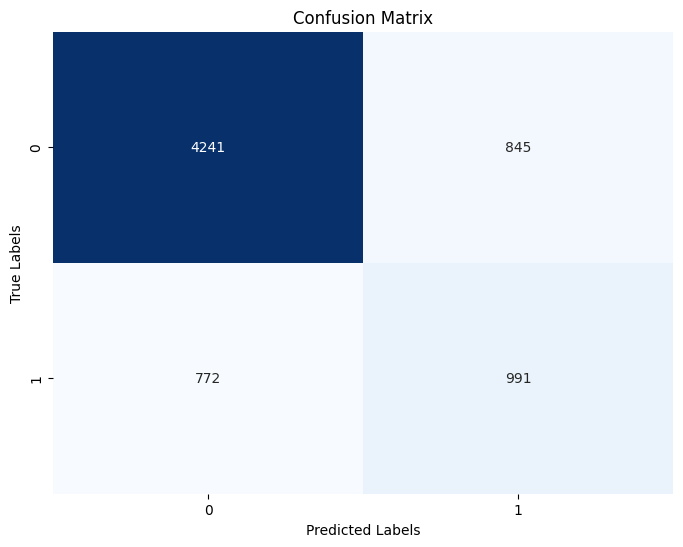

Accuracy: 0.76


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Replace 'y_true' and 'y_pred' with your actual and predicted labels
y_true = esa_labels
y_pred = gmm_labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Display classification report
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display accuracy
print(f"Accuracy: {accuracy:.2f}")


As we can see, the GMM classification is 76% accurate against the ESA classification.

In [20]:
git config --global user.email "wolfna9999@gmail.com"
git config --global user.name "captainbluebear"

/content/drive/MyDrive/GitHub/GEOL0069/assignment-4


In [21]:
! git add .
! git commit -m "all parts complete"
!git push -u origin main

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@e0b642fb0363.(none)')
To https://github.com/captainbluebear/geol0069-assignment4.git
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'https://github.com/captainbluebear/geol0069-assignment4.git'
hint: Updates were rejected because the remote contains work that you do
hint: not have locally. This is usually caused by another repository pushing
hint: to the same ref. You may want to first integrate the remote changes
hint: (e.g., 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.
